# CNN Model using full UBS data now

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Normalization
%matplotlib inline
import seaborn as sns
from keras.models import Sequential 
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, InputLayer
from keras.utils.np_utils import to_categorical

from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


## Part 1: Clean and Select Data

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv("UBS_Cleaned_Date.csv")
df.date = pd.to_datetime(df.date)
df = df.set_index("date")
df = df.iloc[14:, :] # to remove first 14 days that include NaNs due to some calculations
pd.DataFrame(df.isna().sum()).T

,UBS_x,UBS Financial Services Inc.,UBS Investment Bank,UBS Global Wealth Management,UBS Asset Management,Open,High,Low,Close,Volume,Dividends,Stock Splits,UBS_y,Union Bank of Switzerland,UBS tax evasion controversies,Banking in Switzerland,dow_open,dow_high,dow_low,dow_close,dow_vol,nas_open,nas_high,nas_low,nas_close,nas_vol,Wiki_total,Google_total,Stock_total,Nas_total,Dow_total,Wiki_Moment_1,Wiki_Moment_2,Wiki_Moment_1_s,Wiki_Moment_2_s,Wiki_MAvg,Wiki_MAvg_s,Wiki_MAvg_s_5,Wiki_MAvg_s_6,Wiki_Disparity,Wiki_Disparity_s,Wiki_Disparity_s_5,Wiki_ROC,Wiki_ROC_s,Wiki_Rocp,Wiki_EMA,Wiki_EMA_5,Wiki_diff,Wiki_gain,Wiki_loss,Wiki_avg_gain,Wiki_avg_loss,Wiki_rs,Wiki_RSI,Stoch_Oscillator_3,Stoch_Oscillator_14,Change_Close,Change_Google,Wiki_Move,Wiki_MAvg_Move,Wiki_MAvg_s_Move,Wiki_ROC_Move,Wiki_EMA_Move,Wiki_EMA_Move_5,Wiki_Disparity_Move,Wiki_Disparity_s_Move,Wiki_RSI_Move,Google_Moment_1,Google_Moment_2,Google_Moment_1_s,Google_Moment_2_s,Google_MAvg,Google_MAvg_s,Google_MAvg_s_5,Google_MAvg_s_6,Google_Disparity,Google_Disparity_s,Google_Disparity_s_5,Google_ROC,Google_ROC_s,Google_Rocp,Google_EMA,Google_EMA_5,Google_diff,Google_gain,Google_loss,Google_avg_gain,Google_avg_loss,Google_rs,Google_RSI,Google_Move,Google_MAvg_Move,Google_MAvg_s_Move,Google_ROC_Move,Google_EMA_Move,Google_EMA_Move_5,Google_Disparity_Move,Google_Disparity_s_Move,Google_RSI_Move,Stock_Moment_1,Stock_Moment_2,Stock_Moment_1_s,Stock_Moment_2_s,Stock_MAvg,Stock_MAvg_s,Stock_MAvg_s_5,Stock_MAvg_s_6,Stock_Disparity,Stock_Disparity_s,Stock_Disparity_s_5,Stock_ROC,Stock_ROC_s,Stock_Rocp,Stock_EMA,Stock_EMA_5,Stock_diff,Stock_gain,Stock_loss,Stock_avg_gain,Stock_avg_loss,Stock_rs,Stock_RSI,Stock_Move,Stock_MAvg_Move,Stock_MAvg_s_Move,Stock_ROC_Move,Stock_EMA_Move,Stock_EMA_Move_5,Stock_Disparity_Move,Stock_Disparity_s_Move,Stock_RSI_Move,Nas_Moment_1,Nas_Moment_2,Nas_Moment_1_s,Nas_Moment_2_s,Nas_MAvg,Nas_MAvg_s,Nas_MAvg_s_5,Nas_MAvg_s_6,Nas_Disparity,Nas_Disparity_s,Nas_Disparity_s_5,Nas_ROC,Nas_ROC_s,Nas_Rocp,Nas_EMA,Nas_EMA_5,Nas_diff,Nas_gain,Nas_loss,Nas_avg_gain,Nas_avg_loss,Nas_rs,Nas_RSI,Nas_Move,Nas_MAvg_Move,Nas_MAvg_s_Move,Nas_ROC_Move,Nas_EMA_Move,Nas_EMA_Move_5,Nas_Disparity_Move,Nas_Disparity_s_Move,Nas_RSI_Move,Dow_Moment_1,Dow_Moment_2,Dow_Moment_1_s,Dow_Moment_2_s,Dow_MAvg,Dow_MAvg_s,Dow_MAvg_s_5,Dow_MAvg_s_6,Dow_Disparity,Dow_Disparity_s,Dow_Disparity_s_5,Dow_ROC,Dow_ROC_s,Dow_Rocp,Dow_EMA,Dow_EMA_5,Dow_diff,Dow_gain,Dow_loss,Dow_avg_gain,Dow_avg_loss,Dow_rs,Dow_RSI,Dow_Move,Dow_MAvg_Move,Dow_MAvg_s_Move,Dow_ROC_Move,Dow_EMA_Move,Dow_EMA_Move_5,Dow_Disparity_Move,Dow_Disparity_s_Move,Dow_RSI_Move,target_1,target_2,target_3,target_4,target_5
0,18,18,18,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,18,0,0,0,23,23,21,21,15,16,15,15,18,18,18,23,21,23,19,23,19,19,19,32,32,32,32,1,3,1,20,0,0,0,0,0,0,0,0,0,23,23,21,21,15,16,15,15,18,18,18,23,21,23,19,23,19,19,19,32,32,32,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We see from above that some varaibles contain a lot of NaN's so they either might not be useful, or they're going to lead us into eliminating a lot of data points.

To Solve NaN problem we will create two initial data sets, one removing high NaN values, one not, and see which produced better results.

In [6]:
#df = df.drop([['Ford', 'Ford_Bronco_x', 'Ford_Stock', 'F-150', 'Ford_Bronco_y', 'Ford Motor Company', 'Ford F Series', 'Lincoln Navigator', 'Lincoln Aviator']], axis=1)

In [7]:
# High NaN varaibles included will be df_0
df_0 = df.dropna()
df_0 = df_0[~(df_0.isin([np.inf, -np.inf]).any(axis=1))] # to remove inf

# df_1 will remove the high NaN columns
df_1 = df[df.columns.drop(list(df.filter(regex='gain')))]
df_1 = df_1[df_1.columns.drop(list(df_1.filter(regex='loss')))]
df_1 = df_1[df_1.columns.drop(list(df_1.filter(regex='RSI')))]
df_1 = df_1[df_1.columns.drop(list(df_1.filter(regex='_rs')))]
df_1 = df_1.dropna()
df_1 = df_1[~(df_1.isin([np.inf, -np.inf]).any(axis=1))]

df_0.shape,df_1.shape

((748, 200), (762, 165))

In [8]:
# Target Chosen is target_3
df_0 = df_0.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)
df_1 = df_1.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)

target_3_0 = df_0["target_3"]
target_3_1 = df_0["target_3"]

In [9]:
#splitting into training sets 
column_indices = {name: i for i, name in enumerate(df_0.columns)}

n = len(df_0)
train_f0 = df_0[0:int(n*0.7)]
val_f0 = df_0[int(n*0.7):int(n*0.9)]
test_f0 = df_0[int(n*0.9):]

train_f0t = target_3_0[0:int(n*0.7)]
val_f0t = target_3_0[int(n*0.7):int(n*0.9)]
test_f0t = target_3_0[int(n*0.9):]

# now with df_1
n = len(df_1)
train_f1 = df_1[0:int(n*0.7)]
val_f1 = df_1[int(n*0.7):int(n*0.9)]
test_f1 = df_1[int(n*0.9):]

train_f1t = target_3_1[0:int(n*0.7)]
val_f1t = target_3_1[int(n*0.7):int(n*0.9)]
test_f1t = target_3_1[int(n*0.9):]

In [10]:
# preporocessing and standardizing the data
Mscaler = MinMaxScaler() # keeps binarys at zero and 1 :)

train_f0 = pd.DataFrame(Mscaler.fit_transform(train_f0), columns = df_0.columns)
val_f0 = pd.DataFrame(Mscaler.fit_transform(val_f0), columns = df_0.columns)
test_f0 = pd.DataFrame(Mscaler.fit_transform(test_f0), columns = df_0.columns)

train_f1 = pd.DataFrame(Mscaler.fit_transform(train_f1), columns = df_1.columns)
val_f1 = pd.DataFrame(Mscaler.fit_transform(val_f1), columns = df_1.columns)
test_f1 = pd.DataFrame(Mscaler.fit_transform(test_f1), columns = df_1.columns)

In [11]:
# Time series data modifier, will be used later

def df_to_X_y2(df, target, window_size=5):
  df_as_np = df.to_numpy() # converts to matrix of numpy arrays
  X = []
  y = []
  for i in range(len(df_as_np)-window_size): # length of data frame - window_size so it does't take empty values at the end, 
    # does force you to loose the last 5 values, could fix with padding
    row = [r for r in df_as_np[i:i+window_size]] # grabs row i and all rows above within the window size length
    X.append(row) # creates 3 dimentional array, (# obseravtions, # rows in window, # features)
    label = target[i+window_size] # pulls the target variable after the window, target varible needs to be column zero in this 
    y.append(label) # returns (N,) martix of targets i+window_length time periods away
  return np.array(X), np.array(y)

## Switching Focus to Just df_0, High NaN Varibles included

In [12]:
# apply SelectKBest class to extract top 40 best features
bestfeatures = SelectKBest(score_func=f_regression, k=40)
best_fit = bestfeatures.fit(train_f0, train_f0t)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(df_0.columns)

# concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score']  # naming the dataframe columns
print(features_score.nlargest(40, 'Score'))  # print the top 10 best features

                         Features       Score
56                   Change_Close  499.866139
49                      Wiki_loss    3.537357
59                 Wiki_MAvg_Move    2.913996
53                       Wiki_RSI    2.646081
66                  Wiki_RSI_Move    2.633565
112                    Stock_Rocp    2.628453
124             Stock_MAvg_s_Move    2.354298
154                      Nas_Move    2.135456
179                      Dow_diff    1.798386
80                    Google_Rocp    1.721439
60               Wiki_MAvg_s_Move    1.638488
161          Nas_Disparity_s_Move    1.605203
176                      Dow_Rocp    1.592464
2             UBS Investment Bank    1.591836
69              Google_Moment_1_s    1.571602
79                   Google_ROC_s    1.571602
116                    Stock_gain    1.494766
70              Google_Moment_2_s    1.478365
184                        Dow_rs    1.469674
166                Dow_Moment_2_s    1.308038
10                      Dividends 

/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [13]:
feats = list(features_score.nlargest(40, 'Score')['Features'])

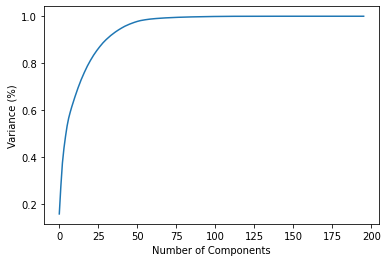

array([ 15.83397769,  27.60003601,  37.50858322,  43.88833547,
        48.88917189,  53.2672383 ,  56.5996076 ,  59.14963451,
        61.45222625,  63.5737241 ,  65.63009239,  67.62225812,
        69.48354866,  71.28702006,  72.95707323,  74.5189978 ,
        76.01283478,  77.44447619,  78.80779229,  80.07205881,
        81.24098137,  82.35245441,  83.43631352,  84.4341931 ,
        85.36970224,  86.27434305,  87.10701614,  87.91715349,
        88.68724553,  89.39270875,  90.04532372,  90.65695026,
        91.24060505,  91.81745313,  92.33268   ,  92.8361845 ,
        93.32600745,  93.78240789,  94.20835914,  94.62749284,
        95.01012962,  95.38509474,  95.74556645,  96.05160644,
        96.34738857,  96.63727549,  96.89788316,  97.14730102,
        97.3788915 ,  97.60377075,  97.80437089,  97.99371146,
        98.14706294,  98.27551567,  98.39257788,  98.49614067,
        98.59764575,  98.69101369,  98.771267  ,  98.84526401,
        98.91110121,  98.9737899 ,  99.02808751,  99.08

In [14]:
# PCA 
pca = PCA().fit(train_f0)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.show()
np.cumsum(pca.explained_variance_ratio_) * 100
# reach 85% variance explained with 25 principle components

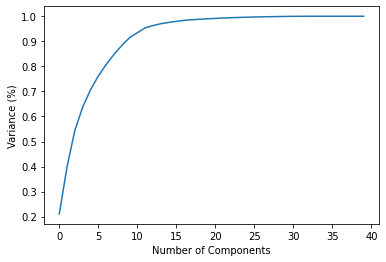

array([ 21.09317012,  40.00020565,  54.48458811,  63.73249966,
        70.6397164 ,  76.15278804,  80.70030185,  84.74212683,
        88.2952194 ,  91.43695872,  93.43065458,  95.3563954 ,
        96.27547839,  97.00889466,  97.52806546,  97.95192943,
        98.35234205,  98.62303134,  98.80382722,  98.96751124,
        99.12924168,  99.28730436,  99.41525631,  99.51662289,
        99.61596873,  99.70779084,  99.76673092,  99.82010665,
        99.87243229,  99.92385075,  99.96961088,  99.98941855,
        99.99795272, 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ])

In [15]:
#PCA with 40 best components
pca_1 = PCA().fit(train_f0[feats])
plt.figure()
plt.plot(np.cumsum(pca_1.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.show()
np.cumsum(pca_1.explained_variance_ratio_) * 100
# can use 9 principle compents now

Keeping score: Will test 5 models with df_0 data variations,
- Model_0_0 = All varaibles,
- Model_0_1 = PCA All varaibles
- Model_0_2 = 40 best k score
- Model_0_3 = PCA of 40 Best K Score

### Model_0_0

In [16]:
# Model_0_0 final data prep

# converting to window format, in this case 5 periods
train_X_0_0, train_f0t_tc = df_to_X_y2(train_f0,train_f0t)
val_X_0_0, val_f0t_tc= df_to_X_y2(val_f0, val_f0t)
test_X_0_0, test_f0t_tc = df_to_X_y2(test_f0,test_f0t) 

In [17]:
len(train_f0t), len(train_X_0_0)

(523, 518)

In [18]:
train_X_0_0.shape[2]

196

In [19]:
n_steps = train_X_0_0.shape[1]
n_features = train_X_0_0.shape[2]

model_0_0_1 = Sequential()
model_0_0_1.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_0_1.add(MaxPooling1D(pool_size=2)) 
model_0_0_1.add(Flatten())
model_0_0_1.add(Dense(50, activation='relu')) 
model_0_0_1.add(Dense(1, activation='sigmoid'))

model_0_0_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_0_1.fit(train_X_0_0, train_f0t_tc,epochs=20,  validation_data=(val_X_0_0, val_f0t_tc))

Epoch 1/20


/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


17/17 [==============================] - 1s 15ms/step - loss: 0.6992 - accuracy: 0.4749 - val_loss: 0.6995 - val_accuracy: 0.4759
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5405 - val_loss: 0.6978 - val_accuracy: 0.5034
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5560 - val_loss: 0.6992 - val_accuracy: 0.4828
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.5541 - val_loss: 0.6988 - val_accuracy: 0.4759
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6808 - accuracy: 0.5811 - val_loss: 0.7030 - val_accuracy: 0.4621
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6767 - accuracy: 0.6042 - val_loss: 0.7022 - val_accuracy: 0.4621
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6730 - accuracy: 0.5830 - val_loss: 0.7009 - val_accuracy: 0.4552
Epoch 8/20
17/17 [============

In [20]:
model_0_0_2 = Sequential()
model_0_0_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_0_2.add(MaxPooling1D(pool_size=2)) 
model_0_0_2.add(Flatten())
model_0_0_2.add(Dense(50, activation='relu')) 
model_0_0_2.add(Dense(1, activation='sigmoid'))

model_0_0_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_0_2.fit(train_X_0_0,train_f0t_tc,epochs=20,  validation_data=(val_X_0_0, val_f0t_tc))

Epoch 1/20
17/17 [==============================] - 2s 22ms/step - loss: 0.7082 - accuracy: 0.4942 - val_loss: 0.6889 - val_accuracy: 0.4966
Epoch 2/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6863 - accuracy: 0.5193 - val_loss: 0.6922 - val_accuracy: 0.5241
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6718 - accuracy: 0.5714 - val_loss: 0.7078 - val_accuracy: 0.5034
Epoch 4/20
17/17 [==============================] - 0s 11ms/step - loss: 0.6664 - accuracy: 0.5695 - val_loss: 0.7075 - val_accuracy: 0.5034
Epoch 5/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6542 - accuracy: 0.6216 - val_loss: 0.7103 - val_accuracy: 0.4966
Epoch 6/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6346 - accuracy: 0.6525 - val_loss: 0.7115 - val_accuracy: 0.4690
Epoch 7/20
17/17 [==============================] - 0s 9ms/step - loss: 0.6297 - accuracy: 0.6486 - val_loss: 0.7151 - val_accuracy: 0.4483
Epoch 8/20
17/17 [

In [21]:
model_0_0_3 = Sequential()
model_0_0_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_0_3.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_0_3.add(MaxPooling1D(pool_size=2)) 
model_0_0_3.add(Flatten())
model_0_0_3.add(Dense(50, activation='relu')) 
model_0_0_3.add(Dense(1, activation='sigmoid')) 

model_0_0_3.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_0_3.fit(train_X_0_0,train_f0t_tc,epochs=20,  validation_data=(val_X_0_0, val_f0t_tc))

Epoch 1/20
17/17 [==============================] - 1s 13ms/step - loss: 0.7022 - accuracy: 0.4749 - val_loss: 0.6930 - val_accuracy: 0.5310
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5386 - val_loss: 0.6982 - val_accuracy: 0.4138
Epoch 3/20
17/17 [==============================] - 0s 8ms/step - loss: 0.6885 - accuracy: 0.5367 - val_loss: 0.6984 - val_accuracy: 0.4621
Epoch 4/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6847 - accuracy: 0.5502 - val_loss: 0.7226 - val_accuracy: 0.4690
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.5521 - val_loss: 0.7082 - val_accuracy: 0.4828
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6865 - accuracy: 0.5598 - val_loss: 0.7028 - val_accuracy: 0.5310
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.5618 - val_loss: 0.7029 - val_accuracy: 0.4483
Epoch 8/20
17/17 [=

In [22]:
model_0_0_4 = Sequential()
model_0_0_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_0_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_0_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_0_4.add(MaxPooling1D(pool_size=2)) 
model_0_0_4.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_0_0_4.add(Flatten())
model_0_0_4.add(Dense(50, activation='relu')) 
model_0_0_4.add(Dense(1, activation='sigmoid')) 
model_0_0_4.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_0_4.fit(train_X_0_0,train_f0t_tc,epochs=20,  validation_data=(val_X_0_0, val_f0t_tc))

Epoch 1/20
17/17 [==============================] - 1s 18ms/step - loss: 0.6993 - accuracy: 0.5174 - val_loss: 0.6949 - val_accuracy: 0.5034
Epoch 2/20
17/17 [==============================] - 0s 10ms/step - loss: 0.6965 - accuracy: 0.4826 - val_loss: 0.6964 - val_accuracy: 0.4483
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6968 - accuracy: 0.5019 - val_loss: 0.6933 - val_accuracy: 0.5241
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.5212 - val_loss: 0.6942 - val_accuracy: 0.5103
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6957 - accuracy: 0.5000 - val_loss: 0.6938 - val_accuracy: 0.5241
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.4981 - val_loss: 0.6916 - val_accuracy: 0.5034
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.5676 - val_loss: 0.6923 - val_accuracy: 0.4897
Epoch 8/20
17/17 [

In [23]:
model_0_0_5 = Sequential()
model_0_0_5.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_0_5.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_0_5.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_0_5.add(MaxPooling1D(pool_size=2)) 
model_0_0_5.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_0_0_5.add(Flatten())
model_0_0_5.add(Dense(50, activation='relu')) 
model_0_0_5.add(Dense(1, activation='sigmoid')) 
model_0_0_5.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_0_5.fit(train_X_0_0,train_f0t_tc,epochs=200,  validation_data=(val_X_0_0, val_f0t_tc))

Epoch 1/200
17/17 [==============================] - 1s 15ms/step - loss: 0.6993 - accuracy: 0.4807 - val_loss: 0.6936 - val_accuracy: 0.4552
Epoch 2/200
17/17 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4961 - val_loss: 0.6926 - val_accuracy: 0.4966
Epoch 3/200
17/17 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.5193 - val_loss: 0.6945 - val_accuracy: 0.4828
Epoch 4/200
17/17 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5135 - val_loss: 0.6931 - val_accuracy: 0.4759
Epoch 5/200
17/17 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4942 - val_loss: 0.6925 - val_accuracy: 0.5310
Epoch 6/200
17/17 [==============================] - 0s 7ms/step - loss: 0.6940 - accuracy: 0.4826 - val_loss: 0.6927 - val_accuracy: 0.5517
Epoch 7/200
17/17 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.5598 - val_loss: 0.6925 - val_accuracy: 0.5241
Epoch 8/200


Model_0_0_3 appears to be an initial best using all the data. Will use this one with the test data.

### Model_0_1

In [24]:
# Model_0_1 final data prep 

# PCA with 23 components to explain 85% of variance
sklearn_pca = PCA(n_components=23)
train_X_0_1 = pd.DataFrame(sklearn_pca.fit_transform(train_f0))
val_X_0_1 = pd.DataFrame(sklearn_pca.transform(val_f0))
test_X_0_1 = pd.DataFrame(sklearn_pca.transform(test_f0))


In [25]:
train_X_0_1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,2.416422,-0.552812,0.131181,0.955582,0.054797,-0.020998,-1.592313,-0.441373,-0.557078,0.159648,-0.284534,0.413303,-0.125948,0.453747,-0.290805,0.545576,-0.413868,0.397605,-0.119679,0.778553,0.096271,-0.375248,-0.225443
1,0.131354,-0.855773,1.585749,0.277939,-0.939847,-0.395470,-0.263718,-0.916463,0.100369,0.197542,-1.024802,0.068028,-0.454410,-1.442645,1.027229,-0.009694,0.796664,-0.479693,-0.706045,-0.516156,0.131170,0.190230,-0.317794
2,-1.897192,-1.635107,-0.421177,-0.404517,-0.592611,0.447623,1.004420,-0.467284,-0.141209,0.407040,0.018325,0.595495,0.871430,-0.449192,0.242426,-0.352698,-0.095071,0.331351,0.435195,0.147930,0.147314,-0.449256,-0.752451
3,0.802775,-1.014436,-1.492656,1.105121,0.010416,-1.161346,-0.260919,0.495378,-0.180611,0.354332,-0.639869,-0.881045,0.955714,-0.484634,0.331929,0.932466,-0.137698,-0.088760,0.172485,-0.181844,-0.280038,0.160299,-0.501305
4,-0.227701,-1.150176,1.192468,0.116273,0.863749,-1.313552,-0.450934,-0.257704,-1.475189,0.416207,0.280944,-1.263506,-0.542511,0.059127,-0.144306,0.593525,0.132372,0.203615,0.523380,-0.556507,0.565145,0.001044,0.057834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,-1.405010,2.413021,-1.302346,-1.454188,-1.071259,-1.011963,0.360309,0.418295,-0.443522,-0.920593,0.135602,-0.436350,0.596886,-1.110165,0.819904,0.142605,0.158831,0.040089,0.376807,0.554216,-0.054865,0.106447,0.042179
519,-0.350725,2.705242,0.145452,-0.643345,1.667632,-0.533822,0.754887,-0.994972,-1.280290,-0.543913,0.974087,0.841912,0.526558,0.049939,-0.601751,-0.228424,-0.437358,0.394419,0.313277,-1.242686,0.251948,0.312916,0.119278
520,-0.014649,3.025190,0.624679,-0.347438,-1.288627,-0.457380,1.237701,-0.423323,-1.149698,-0.241622,-0.104638,-0.340139,-0.787915,-0.033955,-0.164886,0.695858,0.131704,-0.527047,-0.547125,0.333059,-0.168167,0.064260,0.046469
521,0.028352,2.755075,-1.781529,0.560739,0.518674,1.804232,0.127990,0.419765,-0.191832,-0.557436,1.632630,-0.220480,-0.065870,-0.516325,-0.070414,-0.039190,0.523172,-0.405879,-0.051170,-0.280987,-0.161524,0.176334,-0.259446


In [26]:
# reworked function to handle numpy arrays
# Time series data modifier, will be used later

def df_to_X_np(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0] # the y will get thrown out, but for some reason the function refuses to work without it there
    y.append(label)
  return np.array(X), np.array(y)

In [27]:
# converting to window format, in this case 5 periods
train_X_0_1, _ = df_to_X_np(train_X_0_1)
val_X_0_1, _ = df_to_X_np(val_X_0_1)
test_X_0_1, _ = df_to_X_np(test_X_0_1)

In [28]:
n_steps = train_X_0_1.shape[1]
n_features = train_X_0_1.shape[2]

model_0_1_1 = Sequential()
model_0_1_1.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_1_1.add(MaxPooling1D(pool_size=2)) 
model_0_1_1.add(Flatten())
model_0_1_1.add(Dense(50, activation='relu')) 
model_0_1_1.add(Dense(1, activation='sigmoid'))

model_0_1_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_1_1.fit(train_X_0_1, train_f0t_tc,epochs=20,  validation_data=(val_X_0_1, val_f0t_tc))

Epoch 1/20


/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


17/17 [==============================] - 1s 11ms/step - loss: 0.7137 - accuracy: 0.4788 - val_loss: 0.6906 - val_accuracy: 0.5448
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.7031 - accuracy: 0.4788 - val_loss: 0.6902 - val_accuracy: 0.5448
Epoch 3/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.4942 - val_loss: 0.6901 - val_accuracy: 0.5310
Epoch 4/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5039 - val_loss: 0.6931 - val_accuracy: 0.4828
Epoch 5/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6887 - accuracy: 0.5270 - val_loss: 0.6937 - val_accuracy: 0.4621
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.5425 - val_loss: 0.6936 - val_accuracy: 0.4690
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6832 - accuracy: 0.5425 - val_loss: 0.6927 - val_accuracy: 0.4897
Epoch 8/20
17/17 [============

In [29]:
model_0_1_2 = Sequential()
model_0_1_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_1_2.add(MaxPooling1D(pool_size=2)) 
model_0_1_2.add(Flatten())
model_0_1_2.add(Dense(50, activation='relu')) 
model_0_1_2.add(Dense(1, activation='sigmoid'))

model_0_1_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_1_2.fit(train_X_0_1,train_f0t_tc,epochs=20,  validation_data=(val_X_0_1, val_f0t_tc))

Epoch 1/20
17/17 [==============================] - 1s 13ms/step - loss: 0.7015 - accuracy: 0.5270 - val_loss: 0.6948 - val_accuracy: 0.5448
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6625 - accuracy: 0.6081 - val_loss: 0.7055 - val_accuracy: 0.4690
Epoch 3/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6330 - accuracy: 0.6795 - val_loss: 0.7016 - val_accuracy: 0.4966
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6159 - accuracy: 0.6834 - val_loss: 0.7015 - val_accuracy: 0.5310
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5966 - accuracy: 0.7104 - val_loss: 0.7108 - val_accuracy: 0.4759
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5661 - accuracy: 0.7973 - val_loss: 0.7104 - val_accuracy: 0.5172
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5462 - accuracy: 0.7934 - val_loss: 0.7213 - val_accuracy: 0.5034
Epoch 8/20
17/17 [=

In [30]:
model_0_1_3 = Sequential()
model_0_1_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_1_3.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_1_3.add(MaxPooling1D(pool_size=2)) 
model_0_1_3.add(Flatten())
model_0_1_3.add(Dense(50, activation='relu')) 
model_0_1_3.add(Dense(1, activation='sigmoid')) 

model_0_1_3.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_1_3.fit(train_X_0_1,train_f0t_tc,epochs=20,  validation_data=(val_X_0_1, val_f0t_tc))

Epoch 1/20
17/17 [==============================] - 1s 14ms/step - loss: 0.7123 - accuracy: 0.4826 - val_loss: 0.6960 - val_accuracy: 0.5379
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.5772 - val_loss: 0.7043 - val_accuracy: 0.4138
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.6448 - val_loss: 0.7067 - val_accuracy: 0.4414
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6522 - accuracy: 0.6911 - val_loss: 0.7095 - val_accuracy: 0.4552
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6351 - accuracy: 0.7085 - val_loss: 0.7157 - val_accuracy: 0.4552
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.7432 - val_loss: 0.7265 - val_accuracy: 0.4069
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5924 - accuracy: 0.7510 - val_loss: 0.7331 - val_accuracy: 0.4276
Epoch 8/20
17/17 [=

In [31]:
model_0_1_4 = Sequential()
model_0_1_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_1_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_1_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_1_4.add(MaxPooling1D(pool_size=2)) 
model_0_1_4.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_0_1_4.add(Flatten())
model_0_1_4.add(Dense(50, activation='relu')) 
model_0_1_4.add(Dense(1, activation='sigmoid')) 
model_0_1_4.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_1_4.fit(train_X_0_1,train_f0t_tc,epochs=20,  validation_data=(val_X_0_1, val_f0t_tc))

Epoch 1/20
17/17 [==============================] - 2s 25ms/step - loss: 0.6951 - accuracy: 0.4749 - val_loss: 0.6966 - val_accuracy: 0.4138
Epoch 2/20
17/17 [==============================] - 0s 14ms/step - loss: 0.6875 - accuracy: 0.5772 - val_loss: 0.6974 - val_accuracy: 0.4345
Epoch 3/20
17/17 [==============================] - 0s 9ms/step - loss: 0.6801 - accuracy: 0.6004 - val_loss: 0.6995 - val_accuracy: 0.4276
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6667 - accuracy: 0.6757 - val_loss: 0.7005 - val_accuracy: 0.4828
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6447 - accuracy: 0.6969 - val_loss: 0.7161 - val_accuracy: 0.4345
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6150 - accuracy: 0.7239 - val_loss: 0.7201 - val_accuracy: 0.4759
Epoch 7/20
17/17 [==============================] - 0s 8ms/step - loss: 0.5687 - accuracy: 0.7529 - val_loss: 0.7530 - val_accuracy: 0.4207
Epoch 8/20
17/17 [

In [32]:
model_0_1_5 = Sequential()
model_0_1_5.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_1_5.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_1_5.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_1_5.add(MaxPooling1D(pool_size=2)) 
model_0_1_5.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_0_1_5.add(Flatten())
model_0_1_5.add(Dense(50, activation='relu')) 
model_0_1_5.add(Dense(1, activation='sigmoid')) 
model_0_1_5.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_1_5.fit(train_X_0_1,train_f0t_tc,epochs=200,  validation_data=(val_X_0_1, val_f0t_tc))

Epoch 1/200
17/17 [==============================] - 1s 13ms/step - loss: 0.6966 - accuracy: 0.4749 - val_loss: 0.6926 - val_accuracy: 0.4759
Epoch 2/200
17/17 [==============================] - 0s 4ms/step - loss: 0.6842 - accuracy: 0.6236 - val_loss: 0.6934 - val_accuracy: 0.4828
Epoch 3/200
17/17 [==============================] - 0s 4ms/step - loss: 0.6740 - accuracy: 0.6197 - val_loss: 0.6965 - val_accuracy: 0.5103
Epoch 4/200
17/17 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.7239 - val_loss: 0.7023 - val_accuracy: 0.4759
Epoch 5/200
17/17 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.7587 - val_loss: 0.7197 - val_accuracy: 0.4759
Epoch 6/200
17/17 [==============================] - 0s 4ms/step - loss: 0.5609 - accuracy: 0.7548 - val_loss: 0.7575 - val_accuracy: 0.5034
Epoch 7/200
17/17 [==============================] - 0s 5ms/step - loss: 0.4922 - accuracy: 0.7992 - val_loss: 0.8079 - val_accuracy: 0.4483
Epoch 8/200


### Model_0_3

In [33]:
# Model_0_0 final data prep

# converting to window format, in this case 5 periods
train_X_0_2, _ = df_to_X_y2(train_f0[feats],train_f0t)
val_X_0_2, _ = df_to_X_y2(val_f0[feats], val_f0t)
test_X_0_2, _ = df_to_X_y2(test_f0[feats],test_f0t) 

In [34]:
n_steps = train_X_0_2.shape[1]
n_features = train_X_0_2.shape[2]

model_0_2_1 = Sequential()
model_0_2_1.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_2_1.add(MaxPooling1D(pool_size=2)) 
model_0_2_1.add(Flatten())
model_0_2_1.add(Dense(50, activation='relu')) 
model_0_2_1.add(Dense(1, activation='sigmoid'))

model_0_2_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_2_1.fit(train_X_0_2, train_f0t_tc,epochs=20,  validation_data=(val_X_0_2, val_f0t_tc))

Epoch 1/20
17/17 [==============================] - 1s 11ms/step - loss: 0.6965 - accuracy: 0.5039 - val_loss: 0.7021 - val_accuracy: 0.4897
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5135 - val_loss: 0.7018 - val_accuracy: 0.4552
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5058 - val_loss: 0.6994 - val_accuracy: 0.4621
Epoch 4/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.5367 - val_loss: 0.6996 - val_accuracy: 0.4759
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.5386 - val_loss: 0.6994 - val_accuracy: 0.4759
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5541 - val_loss: 0.7006 - val_accuracy: 0.4759
Epoch 7/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5598 - val_loss: 0.7001 - val_accuracy: 0.4828
Epoch 8/20
17/17 [=

In [35]:
model_0_2_2 = Sequential()
model_0_2_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_2_2.add(MaxPooling1D(pool_size=2)) 
model_0_2_2.add(Flatten())
model_0_2_2.add(Dense(50, activation='relu')) 
model_0_2_2.add(Dense(1, activation='sigmoid'))

model_0_2_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_2_2.fit(train_X_0_2,train_f0t_tc,epochs=20,  validation_data=(val_X_0_2, val_f0t_tc))

Epoch 1/20
17/17 [==============================] - 1s 21ms/step - loss: 0.7036 - accuracy: 0.4575 - val_loss: 0.6997 - val_accuracy: 0.4621
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6887 - accuracy: 0.5251 - val_loss: 0.7030 - val_accuracy: 0.4759
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.5907 - val_loss: 0.7022 - val_accuracy: 0.4966
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6737 - accuracy: 0.5888 - val_loss: 0.7039 - val_accuracy: 0.4897
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6707 - accuracy: 0.5907 - val_loss: 0.7054 - val_accuracy: 0.5172
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6626 - accuracy: 0.6158 - val_loss: 0.7108 - val_accuracy: 0.4552
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.5869 - val_loss: 0.7055 - val_accuracy: 0.5172
Epoch 8/20
17/17 [=

In [36]:
model_0_2_3 = Sequential()
model_0_2_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_2_3.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_2_3.add(MaxPooling1D(pool_size=2)) 
model_0_2_3.add(Flatten())
model_0_2_3.add(Dense(50, activation='relu')) 
model_0_2_3.add(Dense(1, activation='sigmoid')) 

model_0_2_3.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_2_3.fit(train_X_0_2,train_f0t_tc,epochs=20,  validation_data=(val_X_0_2, val_f0t_tc))

Epoch 1/20
17/17 [==============================] - 1s 12ms/step - loss: 0.6964 - accuracy: 0.5135 - val_loss: 0.6990 - val_accuracy: 0.4828
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5463 - val_loss: 0.7183 - val_accuracy: 0.4759
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.5734 - val_loss: 0.7082 - val_accuracy: 0.4483
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.5463 - val_loss: 0.7257 - val_accuracy: 0.4621
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6720 - accuracy: 0.6100 - val_loss: 0.7198 - val_accuracy: 0.4276
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6629 - accuracy: 0.6197 - val_loss: 0.7164 - val_accuracy: 0.4483
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6644 - accuracy: 0.6042 - val_loss: 0.7226 - val_accuracy: 0.4069
Epoch 8/20
17/17 [=

In [37]:
model_0_2_4 = Sequential()
model_0_2_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_2_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_2_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_2_4.add(MaxPooling1D(pool_size=2)) 
model_0_2_4.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_0_2_4.add(Flatten())
model_0_2_4.add(Dense(50, activation='relu')) 
model_0_2_4.add(Dense(1, activation='sigmoid')) 
model_0_2_4.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_2_4.fit(train_X_0_2,train_f0t_tc,epochs=20,  validation_data=(val_X_0_2, val_f0t_tc))

Epoch 1/20
17/17 [==============================] - 1s 13ms/step - loss: 0.6963 - accuracy: 0.4749 - val_loss: 0.6913 - val_accuracy: 0.5310
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.4961 - val_loss: 0.6917 - val_accuracy: 0.5034
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5676 - val_loss: 0.6929 - val_accuracy: 0.5310
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5637 - val_loss: 0.6938 - val_accuracy: 0.5172
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5734 - val_loss: 0.7017 - val_accuracy: 0.4759
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6809 - accuracy: 0.5907 - val_loss: 0.7174 - val_accuracy: 0.4759
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6765 - accuracy: 0.5849 - val_loss: 0.7040 - val_accuracy: 0.4897
Epoch 8/20
17/17 [=

Model_0_2_4 best, and most consistent so far

### Model_0_3

# Model_0_1 final data prep

In [38]:
# PCA with 23 components to explain 85% of variance
sklearn_pca = PCA(n_components=8)
train_X_0_3 = pd.DataFrame(sklearn_pca.fit_transform(train_f0[feats]))
val_X_0_3 = pd.DataFrame(sklearn_pca.transform(val_f0[feats]))
test_X_0_3 = pd.DataFrame(sklearn_pca.transform(test_f0[feats]))

In [39]:
train_X_0_3, _ = df_to_X_np(train_X_0_3)
val_X_0_3, _ = df_to_X_np(val_X_0_3)
test_X_0_3, _ = df_to_X_np(test_X_0_3)

In [40]:
n_steps = train_X_0_3.shape[1]
n_features = train_X_0_3.shape[2]

model_0_3_1 = Sequential()
model_0_3_1.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_3_1.add(MaxPooling1D(pool_size=2)) 
model_0_3_1.add(Flatten())
model_0_3_1.add(Dense(50, activation='relu')) 
model_0_3_1.add(Dense(1, activation='sigmoid'))

model_0_3_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_3_1.fit(train_X_0_3, train_f0t_tc,epochs=20,  validation_data=(val_X_0_3, val_f0t_tc))

Epoch 1/20


/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


17/17 [==============================] - 1s 11ms/step - loss: 0.6944 - accuracy: 0.5193 - val_loss: 0.7121 - val_accuracy: 0.4345
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5019 - val_loss: 0.7088 - val_accuracy: 0.4345
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5174 - val_loss: 0.7105 - val_accuracy: 0.4345
Epoch 4/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5444 - val_loss: 0.7123 - val_accuracy: 0.4345
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5444 - val_loss: 0.7093 - val_accuracy: 0.4552
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5444 - val_loss: 0.7103 - val_accuracy: 0.4621
Epoch 7/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5560 - val_loss: 0.7113 - val_accuracy: 0.4552
Epoch 8/20
17/17 [============

In [41]:
model_0_3_2 = Sequential()
model_0_3_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model_0_3_2.add(MaxPooling1D(pool_size=2)) 
model_0_3_2.add(Flatten())
model_0_3_2.add(Dense(50, activation='relu')) 
model_0_3_2.add(Dense(1, activation='sigmoid'))

model_0_3_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_3_2.fit(train_X_0_3,train_f0t_tc,epochs=20,  validation_data=(val_X_0_3, val_f0t_tc))

Epoch 1/20
17/17 [==============================] - 1s 11ms/step - loss: 0.7011 - accuracy: 0.5019 - val_loss: 0.6933 - val_accuracy: 0.5103
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6844 - accuracy: 0.5714 - val_loss: 0.6914 - val_accuracy: 0.5034
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6743 - accuracy: 0.6120 - val_loss: 0.6971 - val_accuracy: 0.5034
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6672 - accuracy: 0.6023 - val_loss: 0.7046 - val_accuracy: 0.4828
Epoch 5/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6892 - val_loss: 0.7018 - val_accuracy: 0.4483
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6873 - val_loss: 0.7033 - val_accuracy: 0.4966
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.7124 - val_loss: 0.7075 - val_accuracy: 0.4897
Epoch 8/20
17/17 [=

In [42]:
model_0_3_3 = Sequential()
model_0_3_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_3_3.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_3_3.add(MaxPooling1D(pool_size=2)) 
model_0_3_3.add(Flatten())
model_0_3_3.add(Dense(50, activation='relu')) 
model_0_3_3.add(Dense(1, activation='sigmoid')) 

model_0_3_3.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_3_3.fit(train_X_0_3,train_f0t_tc,epochs=20,  validation_data=(val_X_0_3, val_f0t_tc))

Epoch 1/20
17/17 [==============================] - 1s 12ms/step - loss: 0.6961 - accuracy: 0.5116 - val_loss: 0.6971 - val_accuracy: 0.4552
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.5753 - val_loss: 0.7022 - val_accuracy: 0.4483
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6725 - accuracy: 0.6409 - val_loss: 0.6988 - val_accuracy: 0.5172
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6661 - accuracy: 0.6023 - val_loss: 0.7051 - val_accuracy: 0.4552
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6615 - accuracy: 0.6158 - val_loss: 0.7122 - val_accuracy: 0.4207
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6448 - val_loss: 0.7115 - val_accuracy: 0.4966
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6330 - accuracy: 0.6737 - val_loss: 0.7280 - val_accuracy: 0.4345
Epoch 8/20
17/17 [=

In [43]:
model_0_3_4 = Sequential()
model_0_3_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_0_3_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_3_4.add(Conv1D(filters=32, kernel_size=2, activation='relu')) 
model_0_3_4.add(MaxPooling1D(pool_size=2)) 
model_0_3_4.add(Conv1D(filters=32, kernel_size=1, activation='relu')) 
model_0_3_4.add(Flatten())
model_0_3_4.add(Dense(50, activation='relu')) 
model_0_3_4.add(Dense(1, activation='sigmoid')) 
model_0_3_4.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["accuracy"])

model_0_3_4.fit(train_X_0_3,train_f0t_tc,epochs=20,  validation_data=(val_X_0_3, val_f0t_tc))

Epoch 1/20
17/17 [==============================] - 1s 14ms/step - loss: 0.6942 - accuracy: 0.4981 - val_loss: 0.6936 - val_accuracy: 0.5034
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.5888 - val_loss: 0.6940 - val_accuracy: 0.4966
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.6699 - val_loss: 0.6958 - val_accuracy: 0.4552
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6712 - accuracy: 0.6486 - val_loss: 0.7008 - val_accuracy: 0.4759
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6514 - accuracy: 0.7104 - val_loss: 0.7065 - val_accuracy: 0.5172
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.7259 - val_loss: 0.7343 - val_accuracy: 0.4345
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.5795 - accuracy: 0.7355 - val_loss: 0.7550 - val_accuracy: 0.4483
Epoch 8/20
17/17 [=

Generally the data from Model_0_3 has been the best. Keeping High NaN variables.

## Modeling with df_1, high NaN Vairables Removed

In [44]:
# apply SelectKBest class to extract top 40 best features
bestfeatures = SelectKBest(score_func=f_regression, k=40)
best_fit = bestfeatures.fit(train_f1, train_f1t)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(df_1.columns)

# concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score']  # naming the dataframe columns
print(features_score.nlargest(40, 'Score'))  # print the top 40 best features

                         Features       Score
160                      target_3  314.255281
50                   Change_Close   96.833439
105                Stock_ROC_Move    4.523183
79             Google_MAvg_s_Move    3.892640
109        Stock_Disparity_s_Move    3.827079
73                    Google_Rocp    3.765494
127                      Nas_Move    3.191416
98                     Stock_Rocp    3.098736
130                  Nas_ROC_Move    2.572110
134          Nas_Disparity_s_Move    2.293653
63              Google_Moment_2_s    2.074318
155                  Dow_ROC_Move    1.813696
15         Banking in Switzerland    1.691470
128                 Nas_MAvg_Move    1.631182
129               Nas_MAvg_s_Move    1.593830
158            Dow_Disparity_Move    1.582640
102                    Stock_Move    1.572636
72                   Google_ROC_s    1.463655
62              Google_Moment_1_s    1.463655
51                  Change_Google    1.434364
108          Stock_Disparity_Move 

/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [45]:
feats_1 = list(features_score.nlargest(40, 'Score')['Features'])

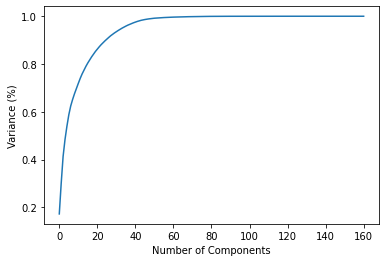

array([ 17.22805243,  30.00751293,  41.28594082,  48.36032554,
        53.89597061,  58.71527909,  62.41786881,  65.14986416,
        67.56707279,  69.77552726,  71.90459631,  73.97764483,
        75.84133656,  77.46534958,  79.03644132,  80.45652409,
        81.76844004,  83.00447846,  84.1671976 ,  85.26028694,
        86.27028551,  87.2067805 ,  88.0994489 ,  88.91808055,
        89.68791942,  90.43553876,  91.13618374,  91.82407212,
        92.4383362 ,  93.00734853,  93.54375614,  94.05515473,
        94.55482226,  95.0180511 ,  95.4595628 ,  95.8659553 ,
        96.25872755,  96.59895077,  96.93344089,  97.25904455,
        97.56066866,  97.82738803,  98.06931441,  98.29141443,
        98.47721441,  98.62573747,  98.76994076,  98.88539118,
        98.99146262,  99.09199367,  99.17607947,  99.2372616 ,
        99.29523866,  99.35220075,  99.40534853,  99.45102161,
        99.49351408,  99.53222451,  99.56902954,  99.60251861,
        99.63204934,  99.65933412,  99.68461448,  99.70

In [46]:
# PCA 
pca = PCA().fit(train_f1)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.show()
np.cumsum(pca.explained_variance_ratio_) * 100
# reach 85% variance explained with 20 principle components

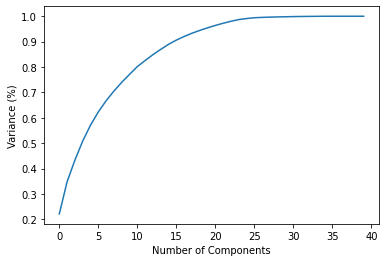

array([ 22.18407368,  34.83097467,  43.35818379,  50.87117424,
        57.12776456,  62.31840641,  66.73121161,  70.55121833,
        73.98398423,  77.11813048,  80.17588291,  82.56954178,
        84.88335785,  86.95894505,  88.95433653,  90.60912771,
        92.0293286 ,  93.3143592 ,  94.42454912,  95.4347556 ,
        96.38595113,  97.2415363 ,  98.0226068 ,  98.6858616 ,
        99.09547952,  99.41188414,  99.55311373,  99.65494261,
        99.73385849,  99.80477162,  99.86351295,  99.90882006,
        99.94005425,  99.96900372,  99.99497902, 100.        ,
       100.        , 100.        , 100.        , 100.        ])

In [47]:
#PCA with 40 best components
pca_1 = PCA().fit(train_f1[feats_1])
plt.figure()
plt.plot(np.cumsum(pca_1.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.show()
np.cumsum(pca_1.explained_variance_ratio_) * 100
# can use 14 principle compents now

Keeping score: Will test 4 models with df_1 data variations,
- Model_1_0 = All varaibles,
- Model_1_1 = PCA All varaibles
- Model_1_2 = 40 best k score
- Model_1_3 = PCA of 40 Best K Score

### Model_1_0

In [48]:
# Model_1_0 final data prep

# converting to window format, in this case 5 periods
train_X_1_0, train_f1t_tc = df_to_X_y2(train_f1,train_f1t)
val_X_1_0, val_f1t_tc= df_to_X_y2(val_f1, val_f1t)
test_X_1_0, test_f1t_tc = df_to_X_y2(test_f1,test_f1t) 

IndexError: index 63 is out of bounds for axis 0 with size 63